# Explore synthetic datasets of geodesics between elementary shapes

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

INFO: Using pytorch backend


In [2]:
import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 5
n_times = 10
n_points = 40

geods_square_rect = synthetic.geodesics_square_to_rectangle(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

geods_circle_ellipse = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

print(geods_square_rect.shape)
print(geods_circle_ellipse.shape)

torch.Size([5, 10, 40, 2])
torch.Size([5, 10, 40, 2])


## Geodesics between square and rectangle

In [3]:
import matplotlib.pyplot as plt

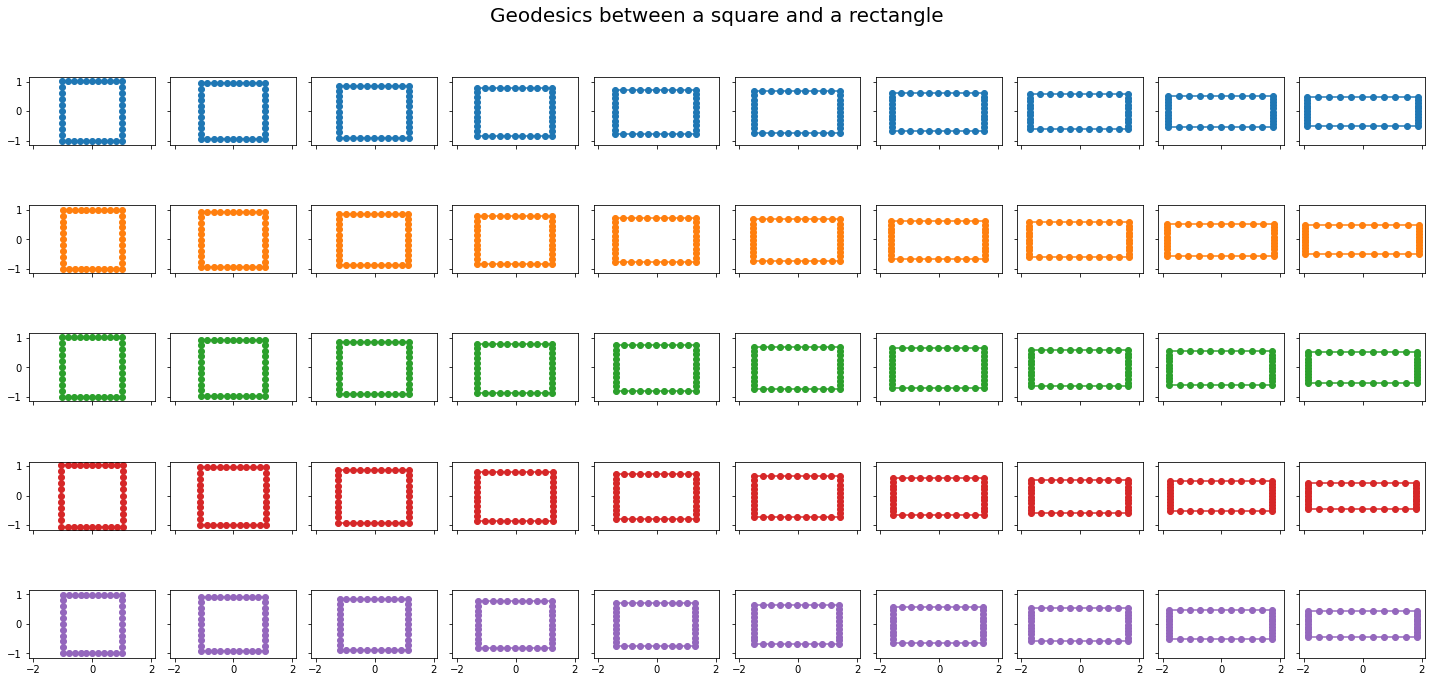

In [46]:
fig, axes = plt.subplots(
    n_geodesics, n_times, figsize=(20, 10), sharex=True, sharey=True
)
fig.suptitle("Geodesics between a square and a rectangle", fontsize=20)

for i_geodesic in range(n_geodesics):
    curve = geods_square_rect[i_geodesic]
    for i_time in range(n_times):
        axes[i_geodesic, i_time].plot(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
        )
        axes[i_geodesic, i_time].set_aspect("equal")
plt.tight_layout()

## Geodesics between circle and ellipse

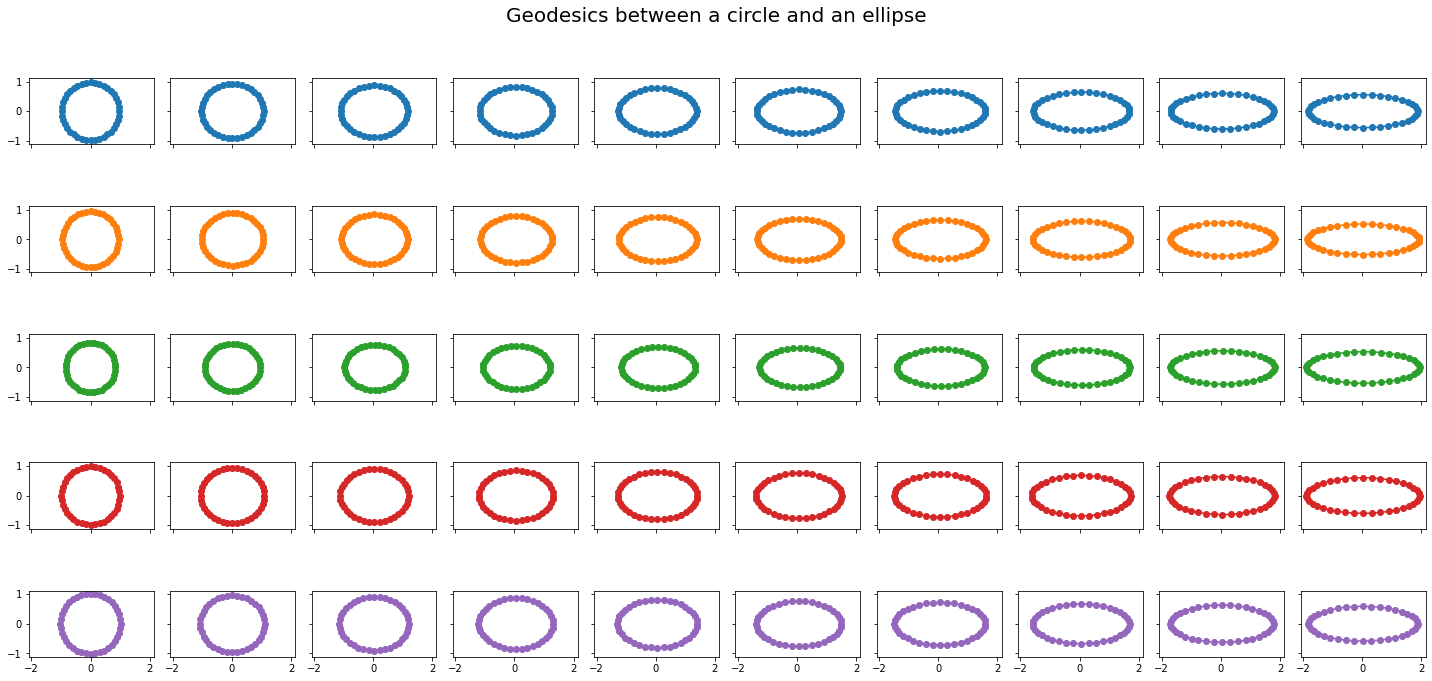

In [45]:
fig, axes = plt.subplots(
    n_geodesics, n_times, figsize=(20, 10), sharex=True, sharey=True
)
fig.suptitle("Geodesics between a circle and an ellipse", fontsize=20)

for i_geodesic in range(n_geodesics):
    curve = geods_circle_ellipse[i_geodesic]
    for i_time in range(n_times):
        axes[i_geodesic, i_time].plot(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_geodesic}"
        )
        axes[i_geodesic, i_time].set_aspect("equal")
plt.tight_layout()

## Plot deformation vector

In [47]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves

CURVES = DiscreteCurves(R2)
METRIC = CURVES.quotient_square_root_velocity_metric

In [58]:
one_geod_square_rect = geods_square_rect[0]
start_square = one_geod_square_rect[0]
end_rect = one_geod_square_rect[-1]

square_deformation_vec = METRIC.log(point=end_rect, base_point=start_square)

print(start_square.shape)
print(square_deformation_vec.shape)

torch.Size([40, 2])
torch.Size([40, 2])


In [59]:
def plot_curve_with_vector(curve, tangent_vec, ax, label_curve=None, label_vec=None):
    ax.plot(curve[:, 0], curve[:, 1], marker="o", c="C0", label=label_curve)
    ax.quiver(
        curve[:, 0], curve[:, 1], tangent_vec[:, 0], tangent_vec[:, 1], label=label_vec
    )
    ax.legend()

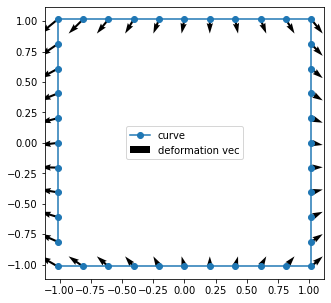

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_curve_with_vector(
    start_square,
    square_deformation_vec,
    ax=ax,
    label_curve="curve",
    label_vec="deformation vec",
)

## Parallel transport initial tangent vector from square to circle

In [52]:
one_geod_circle_ellipse = geods_circle_ellipse[0]
start_circle = one_geod_circle_ellipse[0]
end_ellipse = one_geod_circle_ellipse[-1]

circle_deformation_vec = METRIC.log(point=end_ellipse, base_point=start_circle)

print(one_geod_circle_ellipse.shape)

torch.Size([10, 40, 2])


In [21]:
direction = METRIC.log(point=start_circle, base_point=start_square)
transported_tangent_vec = METRIC.ladder_parallel_transport(
    tangent_vec=square_deformation_vec, base_point=start_square, direction=direction
)["transported_tangent_vec"]

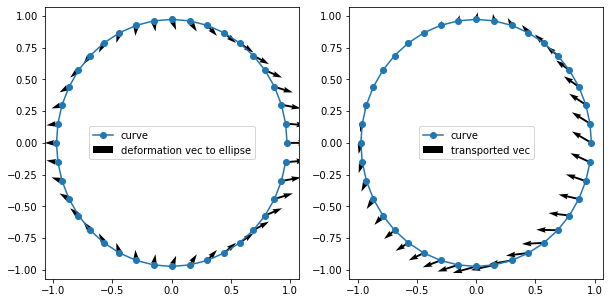

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_curve_with_vector(
    start_circle,
    circle_deformation_vec,
    ax=axes[0],
    label_curve="curve",
    label_vec="deformation vec to ellipse",
)
plot_curve_with_vector(
    start_circle,
    transported_tangent_vec,
    ax=axes[1],
    label_curve="curve",
    label_vec="transported vec",
)

## Deform circle with parallel transported vector

In [22]:
times = gs.arange(0, 1, 1 / n_times)
new_geod_circle_ellipse = METRIC.geodesic(
    initial_curve=start_circle, initial_tangent_vec=transported_tangent_vec
)(times)
print(new_geod_circle_ellipse.shape)

torch.Size([10, 40, 2])


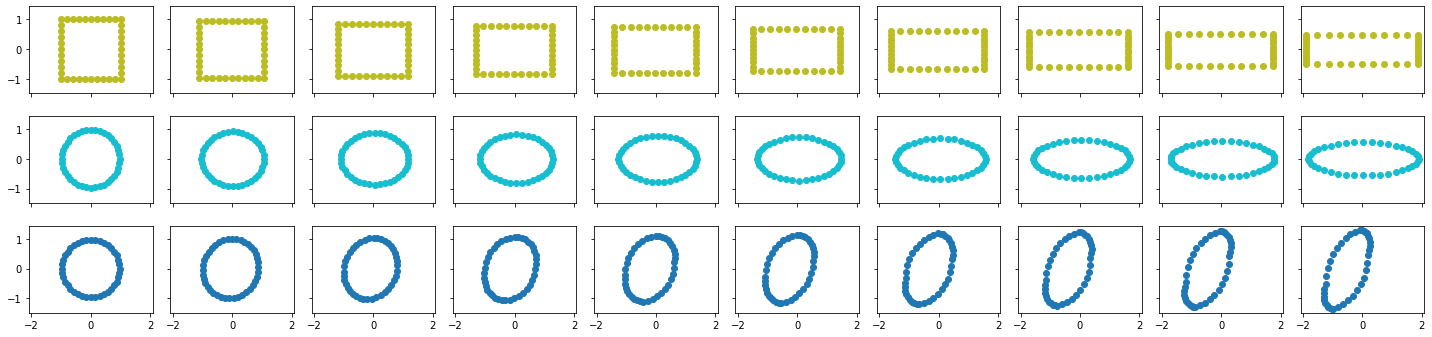

In [64]:
fig, axes = plt.subplots(3, n_times, figsize=(20, 5), sharex=True, sharey=True)

for i_curve, curve in enumerate(
    [one_geod_square_rect, one_geod_circle_ellipse, new_geod_circle_ellipse]
):
    for i_time in range(n_times):
        axes[i_curve, i_time].scatter(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_curve+8}"
        )
        axes[i_curve, i_time].set_aspect("equal")
plt.tight_layout()

In [26]:
rot_mat = gs.array(
    [[gs.cos(gs.pi / 3), -gs.sin(gs.pi / 3)], [gs.sin(gs.pi / 3), gs.cos(gs.pi / 3)]]
)

rot_geod_circle_ellipse = gs.einsum("ij, tni->tnj", rot_mat, new_geod_circle_ellipse)

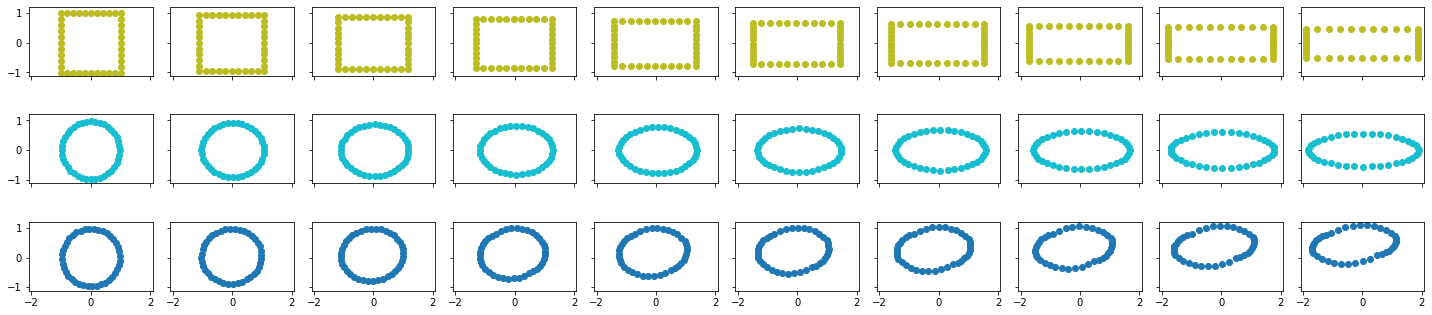

In [65]:
fig, axes = plt.subplots(3, n_times, figsize=(20, 5), sharex=True, sharey=True)

for i_curve, curve in enumerate(
    [one_geod_square_rect, one_geod_circle_ellipse, rot_geod_circle_ellipse]
):
    for i_time in range(n_times):
        axes[i_curve, i_time].plot(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_curve+8}"
        )
        axes[i_curve, i_time].set_aspect("equal")
plt.tight_layout()

## Parallel transport initial tangent vec from circle to square

In [66]:
inverse_direction = METRIC.log(point=start_square, base_point=start_circle)
inverse_transported_tangent_vec = METRIC.ladder_parallel_transport(
    tangent_vec=circle_deformation_vec,
    base_point=start_circle,
    direction=inverse_direction,
)["transported_tangent_vec"]

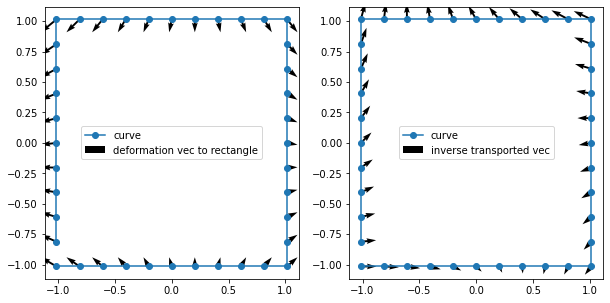

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_curve_with_vector(
    start_square,
    square_deformation_vec,
    ax=axes[0],
    label_curve="curve",
    label_vec="deformation vec to rectangle",
)
plot_curve_with_vector(
    start_square,
    inverse_transported_tangent_vec,
    ax=axes[1],
    label_curve="curve",
    label_vec="inverse transported vec",
)

## Deform square with parallel transported vector

In [69]:
times = gs.arange(0, 1, 1 / n_times)
new_geod_square_rectangle = METRIC.geodesic(
    initial_curve=start_square, initial_tangent_vec=inverse_transported_tangent_vec
)(times)
print(new_geod_square_rectangle.shape)

torch.Size([10, 40, 2])


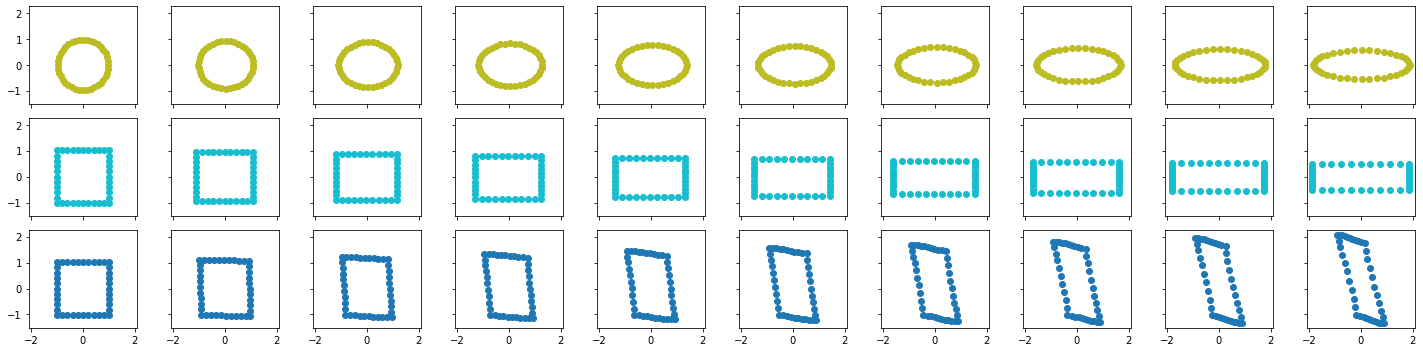

In [70]:
fig, axes = plt.subplots(3, n_times, figsize=(20, 5), sharex=True, sharey=True)

for i_curve, curve in enumerate(
    [one_geod_circle_ellipse, one_geod_square_rect, new_geod_square_rectangle]
):
    for i_time in range(n_times):
        axes[i_curve, i_time].plot(
            curve[i_time][:, 0], curve[i_time][:, 1], marker="o", c=f"C{i_curve+8}"
        )
        axes[i_curve, i_time].set_aspect("equal")
plt.tight_layout()